In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/AMS.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,2.70,2.80,2.70,2.8,2.8,5600
1,1/3/2013,2.75,2.81,2.74,2.8,2.8,4500
2,1/4/2013,2.80,2.80,2.80,2.8,2.8,0
3,1/7/2013,2.75,2.75,2.70,2.7,2.7,400
4,1/8/2013,2.70,2.70,2.60,2.6,2.6,500


In [3]:
from collections import deque
import random
        
class Agent:

    LEARNING_RATE = 0.003
    BATCH_SIZE = 32
    LAYER_SIZE = 256
    OUTPUT_SIZE = 3
    EPSILON = 0.5
    DECAY_RATE = 0.005
    MIN_EPSILON = 0.1
    GAMMA = 0.99
    MEMORIES = deque()
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        tf.reset_default_graph()
        self.INITIAL_FEATURES = np.zeros((4, self.state_size))
        self.X = tf.placeholder(tf.float32, (None, None, self.state_size))
        self.Y = tf.placeholder(tf.float32, (None, self.OUTPUT_SIZE))
        cell = tf.nn.rnn_cell.LSTMCell(self.LAYER_SIZE, state_is_tuple = False)
        self.hidden_layer = tf.placeholder(tf.float32, (None, 2 * self.LAYER_SIZE))
        self.rnn,self.last_state = tf.nn.dynamic_rnn(inputs=self.X,cell=cell,
                                                    dtype=tf.float32,
                                                    initial_state=self.hidden_layer)
        self.logits = tf.layers.dense(self.rnn[:,-1], self.OUTPUT_SIZE)
        self.cost = tf.reduce_sum(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def _memorize(self, state, action, reward, new_state, dead, rnn_state):
        self.MEMORIES.append((state, action, reward, new_state, dead, rnn_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        init_values = np.array([a[-1] for a in replay])
        Q = self.sess.run(self.logits, feed_dict={self.X:states, self.hidden_layer:init_values})
        Q_new = self.sess.run(self.logits, feed_dict={self.X:new_states, self.hidden_layer:init_values})
        replay_size = len(replay)
        X = np.empty((replay_size, 4, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        INIT_VAL = np.empty((replay_size, 2 * self.LAYER_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r, dead_r, rnn_memory = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            if not dead_r:
                target[action_r] += self.GAMMA * np.amax(Q_new[i])
            X[i] = state_r
            Y[i] = target
            INIT_VAL[i] = rnn_memory
        return X, Y, INIT_VAL
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array(res)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        init_value = np.zeros((1, 2 * self.LAYER_SIZE))
        for k in range(self.INITIAL_FEATURES.shape[0]):
            self.INITIAL_FEATURES[k,:] = state
        for t in range(0, len(self.trend) - 1, self.skip):
            action, last_state = self.sess.run([self.logits,self.last_state],
                                                feed_dict={self.X:[self.INITIAL_FEATURES],
                                                            self.hidden_layer:init_value})
            action, init_value = np.argmax(action[0]), last_state
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
            self.INITIAL_FEATURES = new_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
            
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            init_value = np.zeros((1, 2 * self.LAYER_SIZE))
            for k in range(self.INITIAL_FEATURES.shape[0]):
                self.INITIAL_FEATURES[k,:] = state
            for t in range(0, len(self.trend) - 1, self.skip):
                
                if np.random.rand() < self.EPSILON:
                    action = np.random.randint(self.OUTPUT_SIZE)
                else:
                    action, last_state = self.sess.run([self.logits,
                                                  self.last_state],
                                                  feed_dict={self.X:[self.INITIAL_FEATURES],
                                                             self.hidden_layer:init_value})
                    action, init_value = np.argmax(action[0]), last_state
                    
                next_state = self.get_state(t + 1)
                
                if action == 1 and starting_money >= self.trend[t]:
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                    
                invest = ((starting_money - initial_money) / initial_money)
                new_state = np.append([self.get_state(t + 1)], self.INITIAL_FEATURES[:3, :], axis = 0)
                self._memorize(self.INITIAL_FEATURES, action, invest, new_state, 
                               starting_money < initial_money, init_value[0])
                self.INITIAL_FEATURES = new_state
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y, INIT_VAL = self._construct_memories(replay)
                
                cost, _ = self.sess.run([self.cost, self.optimizer], 
                                        feed_dict={self.X: X, self.Y:Y,
                                                  self.hidden_layer: INIT_VAL})
                self.EPSILON = self.MIN_EPSILON + (1.0 - self.MIN_EPSILON) * np.exp(-self.DECAY_RATE * i)
                
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dense instead.
epoch: 10, total rewards: 0.669997.3, cost: 0.000050, total money: 10000.669997
epoch: 20, total rewards: -34.279996.3, cost: 0.000060, total money: 9965.720004
epoch: 30, total rewards: -8.520000.3, cost: 0.000196, total money: 9900.180000
epoch: 40, total rewards: 3.439998.3, cost: 0.000731, total money: 9847.379998
epoch: 50, total rewards: -9.860000.3, cost: 0.000392, total money: 9825.619999
epoch: 60, total rewards: -11.360000.3, cost: 0.000261, total money: 9941.190000

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 18: buy 1 unit at price 2.210000, total balance 9997.790000
day 19, sell 1 unit at price 2.230000, investment 0.904977 %, total balance 10000.020000,
day 25: buy 1 unit at price 2.180000, total balance 9997.840000
day 26: buy 1 unit at price 2.180000, total balance 9995.660000
day 27, sell 1 unit at price 2.180000, investment 0.000000 %, total balance 9997.840000,
day 32: buy 1 unit at price 2.170000, total balance 9995.670000
day 33: buy 1 unit at price 2.260000, total balance 9993.410000
day 34, sell 1 unit at price 2.150000, investment -1.376145 %, total balance 9995.560000,
day 35: buy 1 unit at price 2.110000, total balance 9993.450000
day 36: buy 1 unit at price 2.080000, total balance 9991.370000
day 40: buy 1 unit at price 2.100000, total balance 9989.270000
day 42: buy 1 unit at price 1.970000, total balance 9987.300000
day 43: buy 1 unit at price 1.870000, total balance 9985.430000
day 45: buy 1 unit at price 2.120000, total balance 9983.310000
day 46: buy 1 unit at price

day 194: buy 1 unit at price 2.530000, total balance 9705.800000
day 195: buy 1 unit at price 2.530000, total balance 9703.270000
day 196: buy 1 unit at price 2.460000, total balance 9700.810000
day 197: buy 1 unit at price 2.470000, total balance 9698.340000
day 198: buy 1 unit at price 2.430000, total balance 9695.910000
day 199: buy 1 unit at price 2.540000, total balance 9693.370000
day 200: buy 1 unit at price 2.420000, total balance 9690.950000
day 201: buy 1 unit at price 2.410000, total balance 9688.540000
day 202: buy 1 unit at price 2.450000, total balance 9686.090000
day 203: buy 1 unit at price 2.430000, total balance 9683.660000
day 204: buy 1 unit at price 2.440000, total balance 9681.220000
day 205: buy 1 unit at price 2.410000, total balance 9678.810000
day 206: buy 1 unit at price 2.460000, total balance 9676.350000
day 207: buy 1 unit at price 2.420000, total balance 9673.930000
day 208: buy 1 unit at price 2.430000, total balance 9671.500000
day 209: buy 1 unit at pr

day 348: buy 1 unit at price 2.600000, total balance 9298.730000
day 349: buy 1 unit at price 2.550000, total balance 9296.180000
day 350: buy 1 unit at price 2.590000, total balance 9293.590000
day 351: buy 1 unit at price 2.510000, total balance 9291.080000
day 352: buy 1 unit at price 2.430000, total balance 9288.650000
day 353: buy 1 unit at price 2.410000, total balance 9286.240000
day 354: buy 1 unit at price 2.410000, total balance 9283.830000
day 355: buy 1 unit at price 2.500000, total balance 9281.330000
day 356: buy 1 unit at price 2.550000, total balance 9278.780000
day 357: buy 1 unit at price 2.570000, total balance 9276.210000
day 358: buy 1 unit at price 2.550000, total balance 9273.660000
day 359: buy 1 unit at price 2.440000, total balance 9271.220000
day 360: buy 1 unit at price 2.450000, total balance 9268.770000
day 361: buy 1 unit at price 2.430000, total balance 9266.340000
day 362: buy 1 unit at price 2.400000, total balance 9263.940000
day 363: buy 1 unit at pr

day 494: buy 1 unit at price 2.380000, total balance 8957.410000
day 496: buy 1 unit at price 2.380000, total balance 8955.030000
day 497: buy 1 unit at price 2.430000, total balance 8952.600000
day 498: buy 1 unit at price 2.520000, total balance 8950.080000
day 499: buy 1 unit at price 2.500000, total balance 8947.580000
day 500: buy 1 unit at price 2.510000, total balance 8945.070000
day 501: buy 1 unit at price 2.510000, total balance 8942.560000
day 502: buy 1 unit at price 2.820000, total balance 8939.740000
day 503: buy 1 unit at price 2.810000, total balance 8936.930000
day 504: buy 1 unit at price 2.900000, total balance 8934.030000
day 505: buy 1 unit at price 2.980000, total balance 8931.050000
day 506: buy 1 unit at price 2.810000, total balance 8928.240000
day 507: buy 1 unit at price 2.770000, total balance 8925.470000
day 508: buy 1 unit at price 2.840000, total balance 8922.630000
day 510: buy 1 unit at price 2.700000, total balance 8919.930000
day 511: buy 1 unit at pr

day 646: buy 1 unit at price 2.700000, total balance 8588.680001
day 647: buy 1 unit at price 2.700000, total balance 8585.980001
day 648: buy 1 unit at price 2.680000, total balance 8583.300001
day 649: buy 1 unit at price 2.680000, total balance 8580.620001
day 650: buy 1 unit at price 2.680000, total balance 8577.940001
day 651: buy 1 unit at price 2.580000, total balance 8575.360001
day 652: buy 1 unit at price 2.630000, total balance 8572.730001
day 653: buy 1 unit at price 2.500000, total balance 8570.230001
day 654: buy 1 unit at price 2.510000, total balance 8567.720001
day 655: buy 1 unit at price 2.500000, total balance 8565.220001
day 656: buy 1 unit at price 2.550000, total balance 8562.670001
day 657: buy 1 unit at price 2.540000, total balance 8560.130001
day 658: buy 1 unit at price 2.500000, total balance 8557.630001
day 659: buy 1 unit at price 2.500000, total balance 8555.130001
day 660: buy 1 unit at price 2.500000, total balance 8552.630001
day 661: buy 1 unit at pr

day 795: buy 1 unit at price 1.870000, total balance 8317.500001
day 799: buy 1 unit at price 1.880000, total balance 8315.620001
day 800: buy 1 unit at price 1.900000, total balance 8313.720001
day 801: buy 1 unit at price 1.900000, total balance 8311.820001
day 802: buy 1 unit at price 1.900000, total balance 8309.920001
day 803: buy 1 unit at price 1.980000, total balance 8307.940001
day 804: buy 1 unit at price 1.970000, total balance 8305.970001
day 805: buy 1 unit at price 1.850000, total balance 8304.120001
day 806: buy 1 unit at price 1.890000, total balance 8302.230001
day 807: buy 1 unit at price 1.910000, total balance 8300.320001
day 808: buy 1 unit at price 1.910000, total balance 8298.410001
day 809: buy 1 unit at price 1.890000, total balance 8296.520001
day 810: buy 1 unit at price 1.900000, total balance 8294.620001
day 811: buy 1 unit at price 1.960000, total balance 8292.660001
day 812: buy 1 unit at price 1.970000, total balance 8290.690001
day 813: buy 1 unit at pr

day 960: buy 1 unit at price 3.000000, total balance 8011.610003
day 961: buy 1 unit at price 2.950000, total balance 8008.660003
day 962: buy 1 unit at price 2.980000, total balance 8005.680003
day 963: buy 1 unit at price 2.900000, total balance 8002.780003
day 964: buy 1 unit at price 3.000000, total balance 7999.780003
day 965: buy 1 unit at price 3.000000, total balance 7996.780003
day 966: buy 1 unit at price 2.900000, total balance 7993.880002
day 967: buy 1 unit at price 3.000000, total balance 7990.880002
day 968: buy 1 unit at price 2.860000, total balance 7988.020003
day 969: buy 1 unit at price 2.800000, total balance 7985.220003
day 970: buy 1 unit at price 2.700000, total balance 7982.520003
day 971: buy 1 unit at price 2.750000, total balance 7979.770003
day 972: buy 1 unit at price 2.850000, total balance 7976.920003
day 973: buy 1 unit at price 3.300000, total balance 7973.620003
day 974: buy 1 unit at price 3.250000, total balance 7970.370003
day 975: buy 1 unit at pr

day 1143: buy 1 unit at price 3.900000, total balance 7472.590001
day 1146: buy 1 unit at price 3.950000, total balance 7468.640001
day 1147: buy 1 unit at price 4.000000, total balance 7464.640001
day 1148: buy 1 unit at price 4.050000, total balance 7460.590001
day 1149: buy 1 unit at price 4.000000, total balance 7456.590001
day 1150: buy 1 unit at price 3.900000, total balance 7452.690001
day 1151: buy 1 unit at price 3.800000, total balance 7448.890001
day 1152: buy 1 unit at price 3.750000, total balance 7445.140001
day 1153: buy 1 unit at price 3.700000, total balance 7441.440001
day 1154: buy 1 unit at price 3.650000, total balance 7437.790000
day 1155: buy 1 unit at price 3.550000, total balance 7434.240000
day 1156: buy 1 unit at price 3.400000, total balance 7430.840000
day 1157: buy 1 unit at price 3.500000, total balance 7427.340000
day 1158: buy 1 unit at price 3.400000, total balance 7423.940000
day 1159: buy 1 unit at price 3.350000, total balance 7420.590000
day 1160: 

day 1299: buy 1 unit at price 2.600000, total balance 7057.330003
day 1300: buy 1 unit at price 2.600000, total balance 7054.730003
day 1301: buy 1 unit at price 2.550000, total balance 7052.180003
day 1302: buy 1 unit at price 2.550000, total balance 7049.630003
day 1303: buy 1 unit at price 2.550000, total balance 7047.080003
day 1304: buy 1 unit at price 2.550000, total balance 7044.530003
day 1305: buy 1 unit at price 2.600000, total balance 7041.930003
day 1306: buy 1 unit at price 2.600000, total balance 7039.330003
day 1307: buy 1 unit at price 2.550000, total balance 7036.780003
day 1308: buy 1 unit at price 2.600000, total balance 7034.180003
day 1309: buy 1 unit at price 2.600000, total balance 7031.580003
day 1310: buy 1 unit at price 2.550000, total balance 7029.030003
day 1311: buy 1 unit at price 2.600000, total balance 7026.430003
day 1312: buy 1 unit at price 2.600000, total balance 7023.830003
day 1313: buy 1 unit at price 2.600000, total balance 7021.230004
day 1314: 

day 1456: buy 1 unit at price 3.370000, total balance 6634.990004
day 1458: buy 1 unit at price 3.400000, total balance 6631.590004
day 1459: buy 1 unit at price 3.580000, total balance 6628.010004
day 1460: buy 1 unit at price 3.360000, total balance 6624.650004
day 1461: buy 1 unit at price 3.280000, total balance 6621.370004
day 1462: buy 1 unit at price 3.380000, total balance 6617.990004
day 1464: buy 1 unit at price 3.120000, total balance 6614.870004
day 1466, sell 1 unit at price 3.080000, investment 56.345172 %, total balance 6617.950004,
day 1468: buy 1 unit at price 3.170000, total balance 6614.780004
day 1469: buy 1 unit at price 3.150000, total balance 6611.630004
day 1470: buy 1 unit at price 3.170000, total balance 6608.460004
day 1471: buy 1 unit at price 3.180000, total balance 6605.280004
day 1472: buy 1 unit at price 3.240000, total balance 6602.040004
day 1474: buy 1 unit at price 3.230000, total balance 6598.810004
day 1475: buy 1 unit at price 2.860000, total bala

day 1624: buy 1 unit at price 3.030000, total balance 6248.380005
day 1625: buy 1 unit at price 2.950000, total balance 6245.430005
day 1626: buy 1 unit at price 3.210000, total balance 6242.220005
day 1627: buy 1 unit at price 3.200000, total balance 6239.020005
day 1628: buy 1 unit at price 3.030000, total balance 6235.990005
day 1629: buy 1 unit at price 2.940000, total balance 6233.050004
day 1630: buy 1 unit at price 2.970000, total balance 6230.080004
day 1631: buy 1 unit at price 2.950000, total balance 6227.130004
day 1634: buy 1 unit at price 2.990000, total balance 6224.140004
day 1635: buy 1 unit at price 3.020000, total balance 6221.120004
day 1636: buy 1 unit at price 2.970000, total balance 6218.150004
day 1637: buy 1 unit at price 2.950000, total balance 6215.200004
day 1638: buy 1 unit at price 2.920000, total balance 6212.280004
day 1639: buy 1 unit at price 2.800000, total balance 6209.480004
day 1640: buy 1 unit at price 2.950000, total balance 6206.530004
day 1641: 

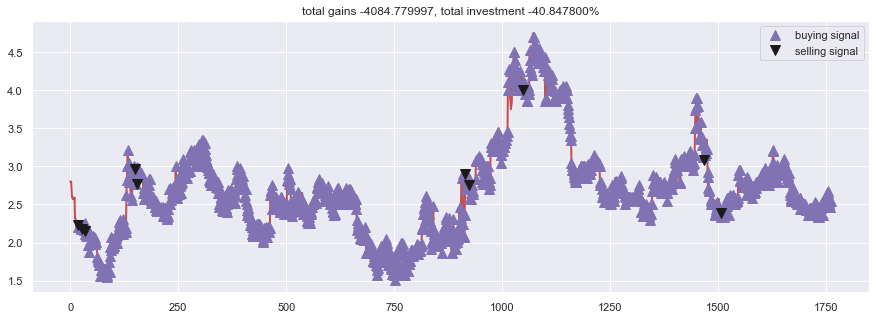

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()